**NAME : SAPTARSHI MUKHERJEE.**


## **Introduction**
This project aims to predict customer churn for a telecom company using machine learning techniques. The analysis involves data generation, exploratory data analysis (EDA), preprocessing, model training, and evaluation.

**Importing Library**

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import warnings
import xgboost as xgb

warnings.filterwarnings('ignore')

**Generate synthetic data**



In [41]:
n_samples = 5000

customer_id = np.arange(1, n_samples + 1)
age = np.random.randint(18, 80, n_samples)
gender = np.random.choice(['Male', 'Female'], n_samples)
contract_type = np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples, p=[0.6, 0.3, 0.1])
monthly_charges = np.random.uniform(20, 100, n_samples)
tenure = np.random.randint(1, 72, n_samples)
total_charges = monthly_charges * tenure + np.random.normal(0, 50, n_samples)
tech_support = np.random.choice(['Yes', 'No'], n_samples)
internet_service = np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples, p=[0.4, 0.5, 0.1])
paperless_billing = np.random.choice(['Yes', 'No'], n_samples)
payment_method = np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_samples)


## Create DataFrame

In [42]:
# Create DataFrame
df = pd.DataFrame({
    'CustomerID': customer_id,
    'Age': age,
    'Gender': gender,
    'ContractType': contract_type,
    'MonthlyCharges': monthly_charges,
    'TotalCharges': total_charges,
    'TechSupport': tech_support,
    'InternetService': internet_service,
    'Tenure': tenure,
    'PaperlessBilling': paperless_billing,
    'PaymentMethod': payment_method,
    'AverageMonthlyCharges': total_charges / tenure,
    'CustomerLifetimeValue': total_charges * np.random.uniform(0.8, 1.2, n_samples),
})

# Introduce some missing values
df.loc[np.random.choice(df.index, 100), 'TotalCharges'] = np.nan
df.loc[np.random.choice(df.index, 50), 'MonthlyCharges'] = np.nan

# Feature Engineering
df['TenureSquared'] = df['Tenure'] ** 2
df['MonthlyChargesLog'] = np.log(df['MonthlyCharges'])
df['TotalChargesLog'] = np.log(df['TotalCharges'])
df['MonthlyChargesPerTenure'] = df['MonthlyCharges'] / df['Tenure']
df['TotalChargesPerTenure'] = df['TotalCharges'] / df['Tenure']

# Generate churn based on some rules to introduce correlation
churn_prob = (
    0.1 +
    0.1 * (df['ContractType'] == 'Month-to-month') +
    0.05 * (df['InternetService'] == 'Fiber optic') +
    0.05 * (df['TechSupport'] == 'No') +
    0.1 * (df['Tenure'] < 12) +
    0.05 * (df['MonthlyCharges'] > 70) +
    0.05 * (df['PaperlessBilling'] == 'Yes') +
    0.05 * (df['PaymentMethod'] == 'Electronic check')
)
df['Churn'] = np.random.binomial(1, churn_prob)

print("Dataset generated successfully.")
print(f"Shape of the dataset: {df.shape}")
print(f"Churn rate: {df['Churn'].mean():.2%}")

df.info()

print("\nMissing Values:")
print(df.isnull().sum())

Dataset generated successfully.
Shape of the dataset: (5000, 19)
Churn rate: 28.14%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               5000 non-null   int64  
 1   Age                      5000 non-null   int64  
 2   Gender                   5000 non-null   object 
 3   ContractType             5000 non-null   object 
 4   MonthlyCharges           4951 non-null   float64
 5   TotalCharges             4900 non-null   float64
 6   TechSupport              5000 non-null   object 
 7   InternetService          5000 non-null   object 
 8   Tenure                   5000 non-null   int64  
 9   PaperlessBilling         5000 non-null   object 
 10  PaymentMethod            5000 non-null   object 
 11  AverageMonthlyCharges    5000 non-null   float64
 12  CustomerLifetimeValue    5000 non-null   float64

## Visualization

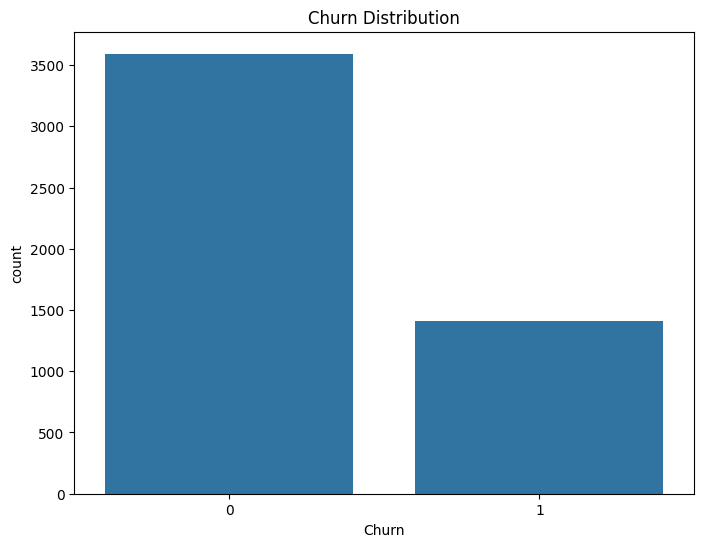

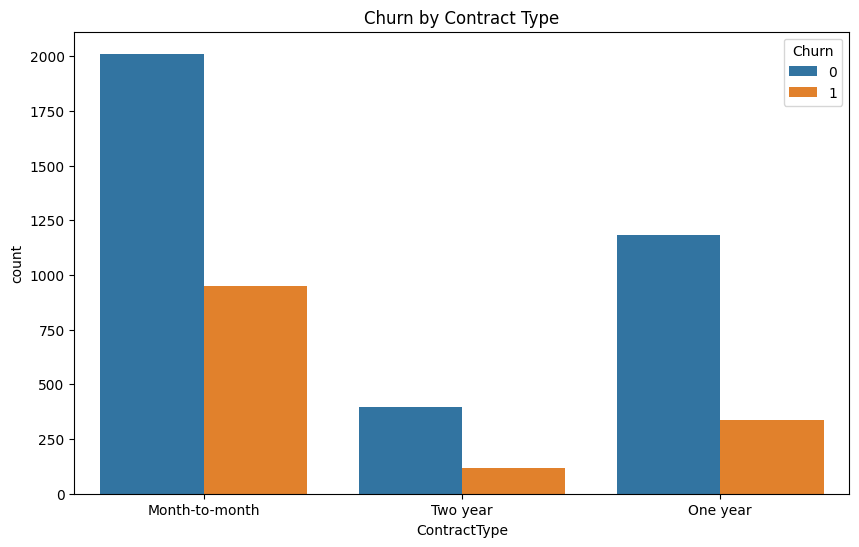

In [43]:
# Visualization 1: Churn Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# Visualization 2: Churn by Contract Type
plt.figure(figsize=(10, 6))
sns.countplot(x='ContractType', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

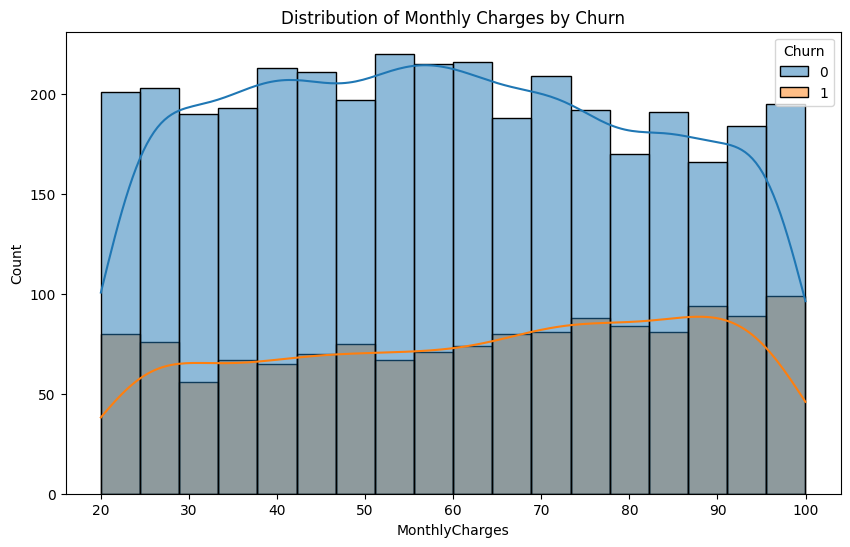

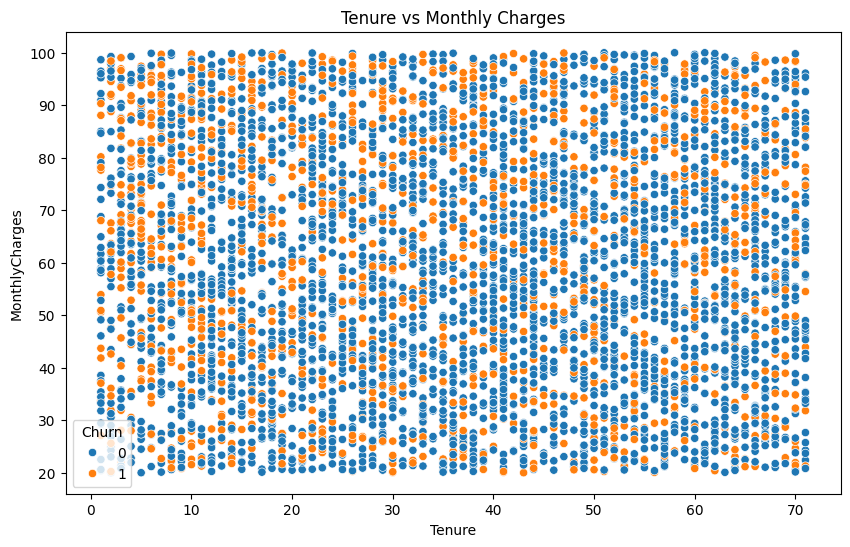

In [44]:
# Visualization 3: Monthly Charges Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True)
plt.title('Distribution of Monthly Charges by Churn')
plt.show()

# Visualization 4: Tenure vs Monthly Charges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Tenure', y='MonthlyCharges', hue='Churn')
plt.title('Tenure vs Monthly Charges')
plt.show()

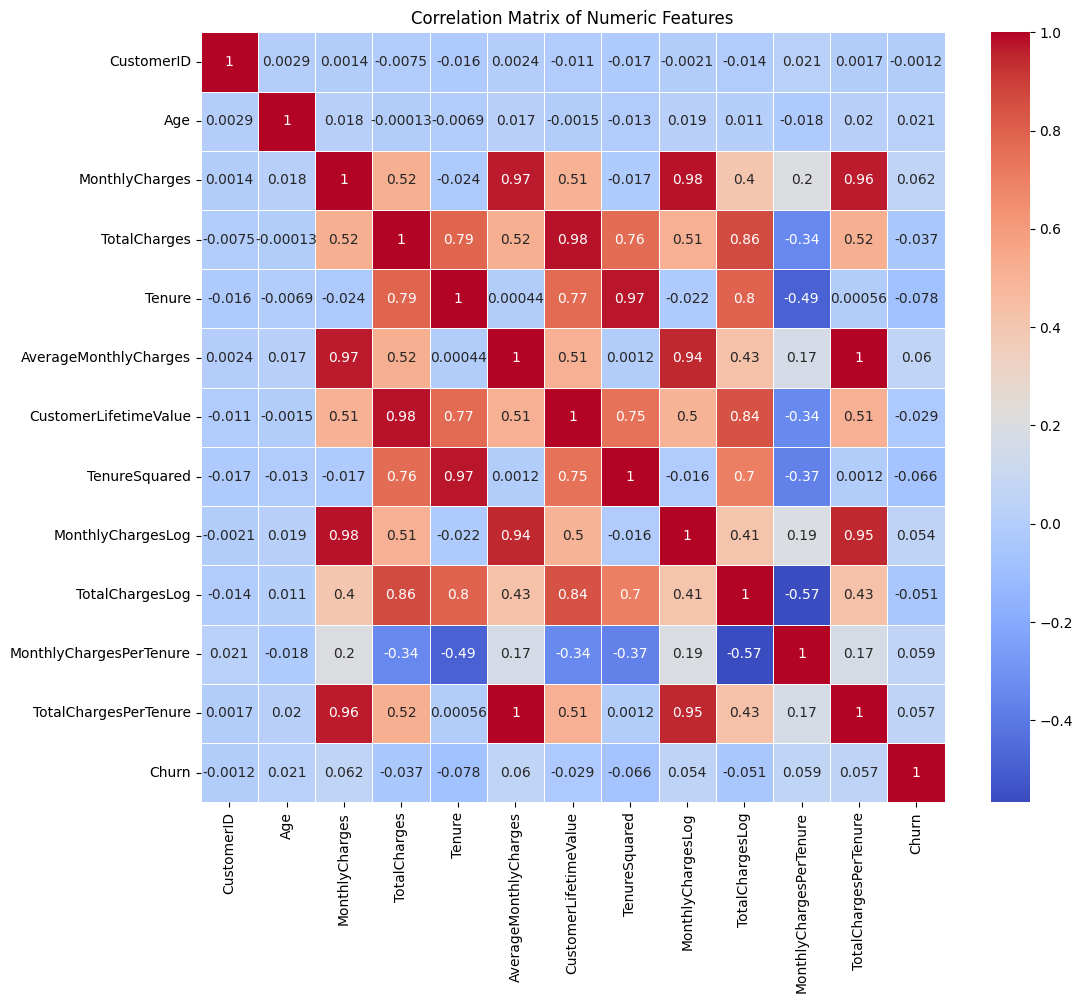

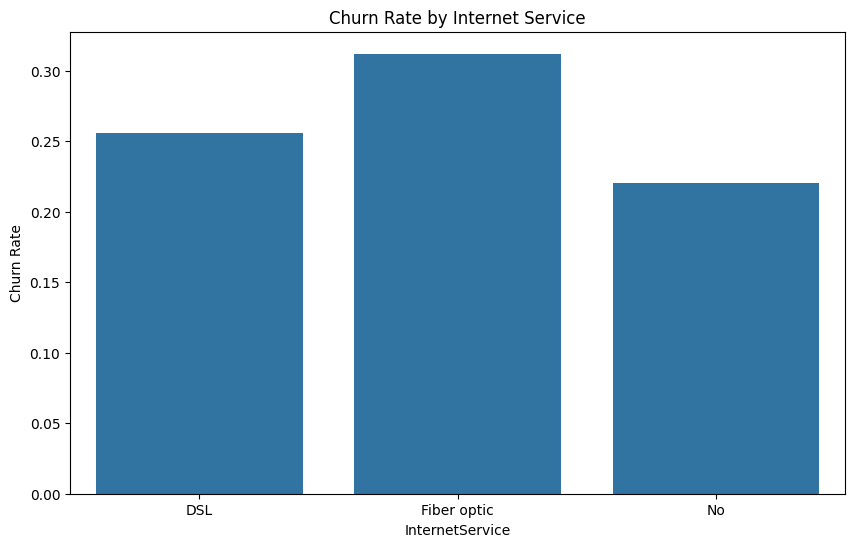

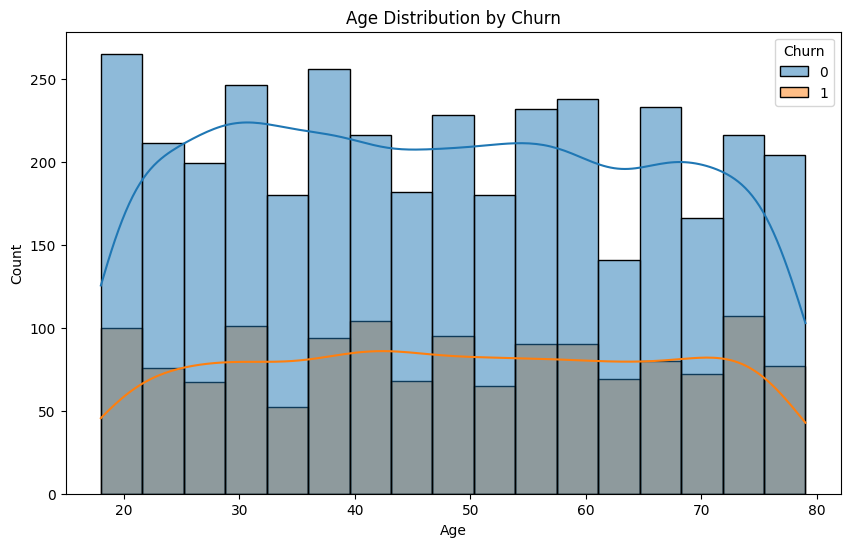

In [45]:
# Visualization 5: Correlation Heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Visualization 6: Churn Rate by Internet Service
plt.figure(figsize=(10, 6))
churn_rate = df.groupby('InternetService')['Churn'].mean()
sns.barplot(x=churn_rate.index, y=churn_rate.values)
plt.title('Churn Rate by Internet Service')
plt.ylabel('Churn Rate')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Churn', kde=True)
plt.title('Age Distribution by Churn')
plt.show()


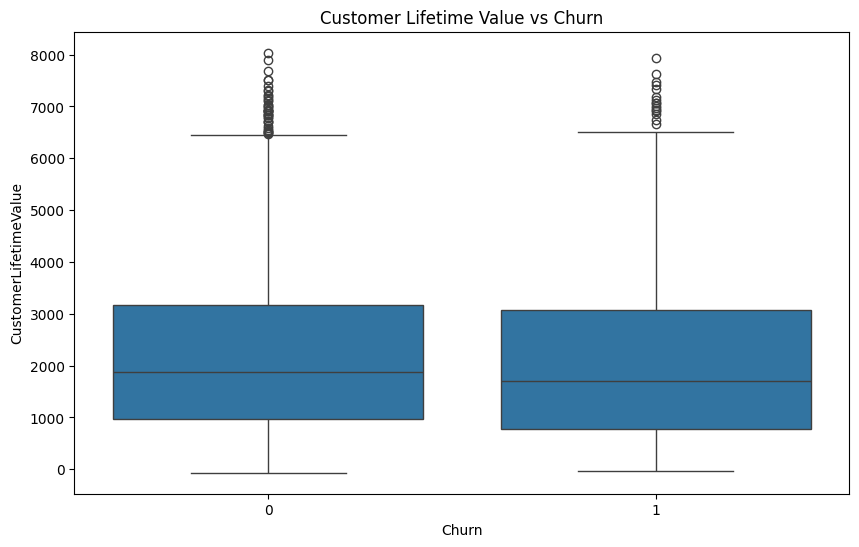


Key Insights from EDA:
1. Churn Rate: 28.14%
2. Average Monthly Charges: $60.12
3. Average Tenure: 36.41 months
4. Most Common Contract Type: Month-to-month
5. Most Common Internet Service: Fiber optic


In [46]:
# Visualization 8: Customer Lifetime Value vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='CustomerLifetimeValue', data=df)
plt.title('Customer Lifetime Value vs Churn')
plt.show()

print("\nKey Insights from EDA:")
print("1. Churn Rate: {:.2%}".format(df['Churn'].mean()))
print("2. Average Monthly Charges: ${:.2f}".format(df['MonthlyCharges'].mean()))
print("3. Average Tenure: {:.2f} months".format(df['Tenure'].mean()))
print("4. Most Common Contract Type:", df['ContractType'].mode()[0])
print("5. Most Common Internet Service:", df['InternetService'].mode()[0])

In [47]:
# Calculate churn rate by contract type
churn_by_contract = df.groupby('ContractType')['Churn'].mean().sort_values(ascending=False)
print("\nChurn Rate by Contract Type:")
print(churn_by_contract)

# Calculate average monthly charges by internet service
avg_charges_by_internet = df.groupby('InternetService')['MonthlyCharges'].mean().sort_values(ascending=False)
print("\nAverage Monthly Charges by Internet Service:")
print(avg_charges_by_internet)

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Churn Rate by Contract Type:
ContractType
Month-to-month    0.320958
Two year          0.231068
One year          0.221419
Name: Churn, dtype: float64

Average Monthly Charges by Internet Service:
InternetService
Fiber optic    60.578955
DSL            60.215213
No             57.232536
Name: MonthlyCharges, dtype: float64

Summary Statistics:
        CustomerID          Age  MonthlyCharges  TotalCharges       Tenure  \
count  5000.000000  5000.000000     4951.000000   4900.000000  5000.000000   
mean   2500.500000    47.836000       60.119044   2180.321080    36.408200   
std    1443.520003    17.799036       23.010829   1547.867657    20.337657   
min       1.000000    18.000000       20.026459    -64.934278     1.000000   
25%    1250.750000    32.000000       40.381318    936.093335    19.000000   
50%    2500.500000    48.000000       60.067842   1838.599104    37.000000   
75%    3750.250000    63.000000       79.852230   3161.238345    54.000000   
max    5000.000000    79.0000


Categorical Data Distributions:

Gender:
Gender
Male      0.5078
Female    0.4922
Name: proportion, dtype: float64

ContractType:
ContractType
Month-to-month    0.5926
One year          0.3044
Two year          0.1030
Name: proportion, dtype: float64

TechSupport:
TechSupport
Yes    0.5056
No     0.4944
Name: proportion, dtype: float64

InternetService:
InternetService
Fiber optic    0.5138
DSL            0.3918
No             0.0944
Name: proportion, dtype: float64

PaperlessBilling:
PaperlessBilling
Yes    0.5056
No     0.4944
Name: proportion, dtype: float64

PaymentMethod:
PaymentMethod
Electronic check    0.2638
Credit card         0.2512
Mailed check        0.2476
Bank transfer       0.2374
Name: proportion, dtype: float64


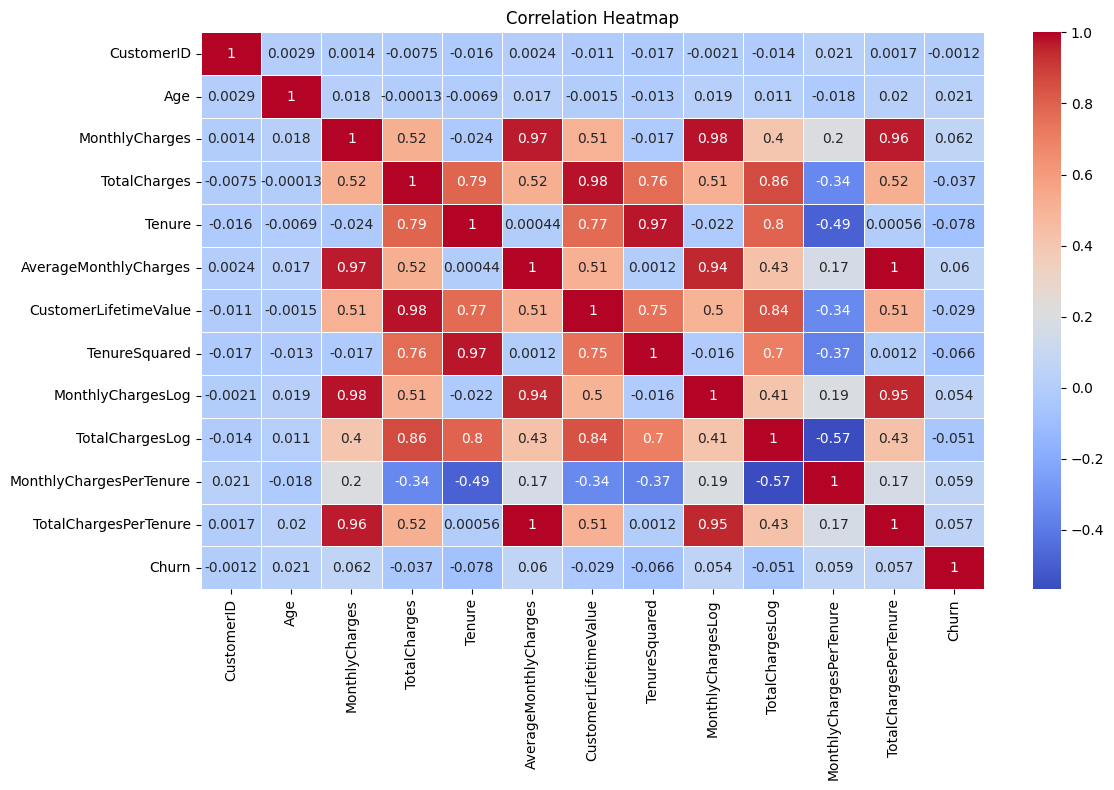

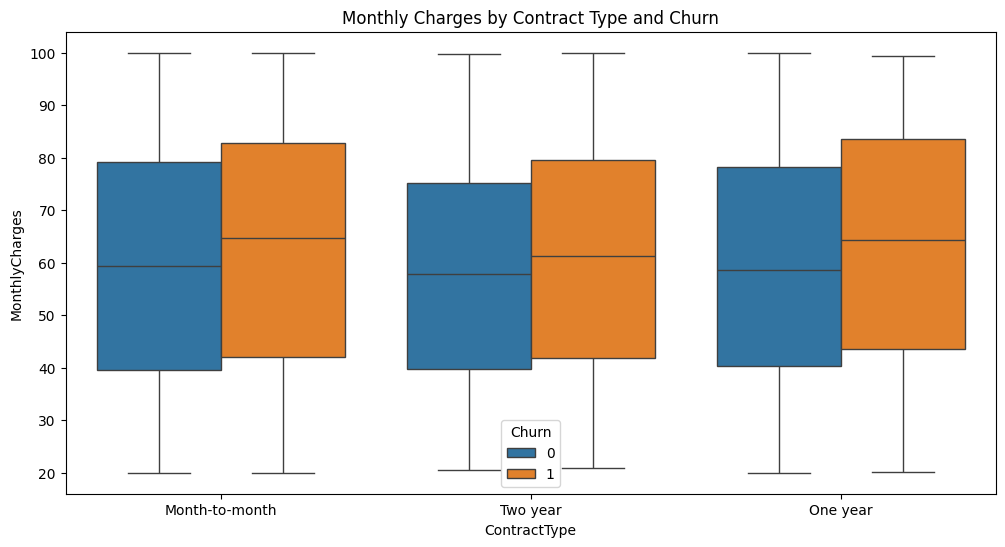

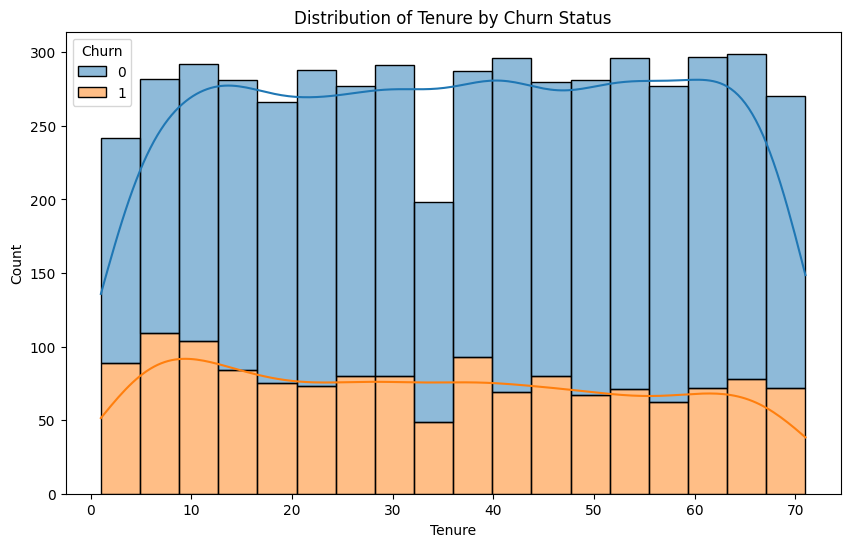

In [48]:

# Categorical data distributions
print("\nCategorical Data Distributions:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True))

# Visualizations
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='ContractType', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Monthly Charges by Contract Type and Churn')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Tenure', hue='Churn', multiple='stack', kde=True)
plt.title('Distribution of Tenure by Churn Status')
plt.show()

 **Data Preprocessing**


In [49]:
X = df.drop(['Churn', 'CustomerID'], axis=1)
y = df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_features = ['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure', 'AverageMonthlyCharges', 'CustomerLifetimeValue']
categorical_features = ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod']

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Data preprocessing completed.")
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")


Data preprocessing completed.
Processed training data shape: (4000, 22)
Processed testing data shape: (1000, 22)


# *Experimenting with Logistic Regression, Decision Tree, RandomForest, and XGBoost classifier*

In [50]:
# Logistic Regression
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

lr_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

lr_random_search = RandomizedSearchCV(lr_model, lr_param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42)
lr_random_search.fit(X_train, y_train)

print("Best Logistic Regression parameters:", lr_random_search.best_params_)
lr_best_model = lr_random_search.best_estimator_

Best Logistic Regression parameters: {'classifier__penalty': 'l2', 'classifier__C': 0.001}


In [51]:
# Decision Tree
dt_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8]
}

dt_random_search = RandomizedSearchCV(dt_model, dt_param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42)
dt_random_search.fit(X_train, y_train)

dt_best_model = dt_random_search.best_estimator_
print("Best Decision Tree parameters:", dt_random_search.best_params_)

Best Decision Tree parameters: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3}


In [52]:
# RandomForest
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(rf_model, rf_param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train, y_train)

rf_best_model = rf_random_search.best_estimator_
print("Best RandomForest parameters:", rf_random_search.best_params_)

Best RandomForest parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10}


In [53]:
# XGBoost
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

xgb_random_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_random_search.fit(X_train, y_train)

xgb_best_model = xgb_random_search.best_estimator_
print("Best XGBoost parameters:", xgb_random_search.best_params_)

Best XGBoost parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}


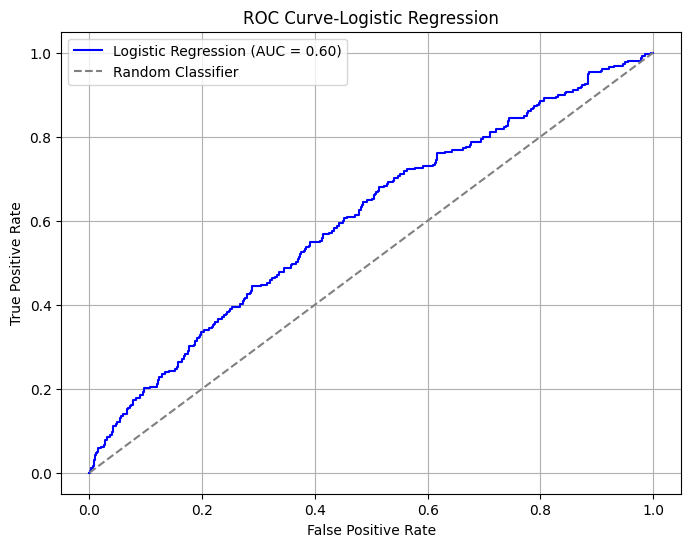

In [54]:
# Predict probabilities
y_probs = lr_best_model.predict_proba(X_test)[:, 1]  # Only need probabilities for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve-Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


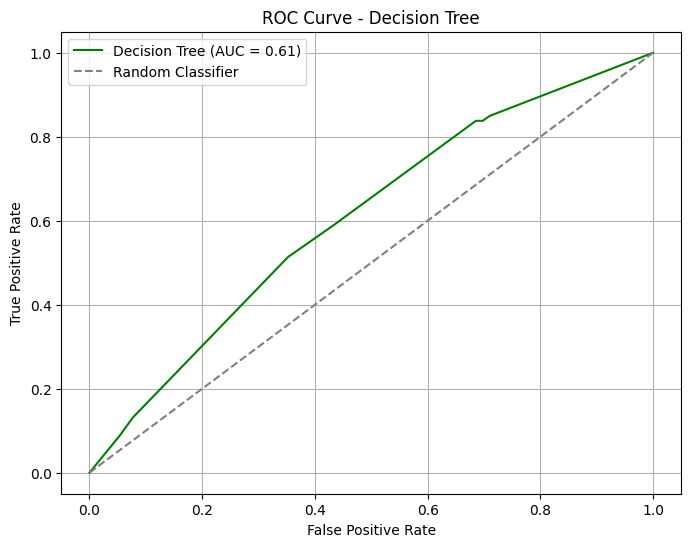

In [55]:
# Predict probabilities for the positive class
y_probs_dt = dt_best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for the Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_probs_dt)

# Calculate the AUC (Area Under the Curve) for the Decision Tree
auc_dt = roc_auc_score(y_test, y_probs_dt)

# Plot the ROC curve for the Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve - Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

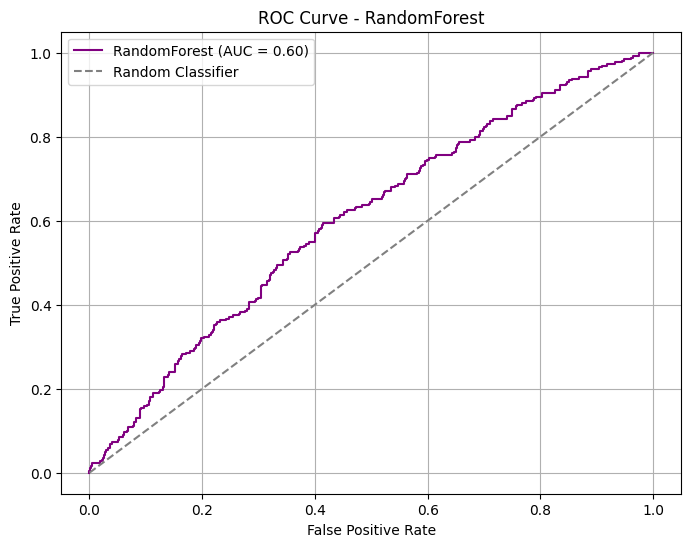

In [56]:
# Predict probabilities for the positive class using the RandomForest model
y_probs_rf = rf_best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for the RandomForest model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)

# Calculate the AUC (Area Under the Curve) for the RandomForest model
auc_rf = roc_auc_score(y_test, y_probs_rf)

# Plot the ROC curve for the RandomForest model
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc_rf:.2f})', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve - RandomForest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


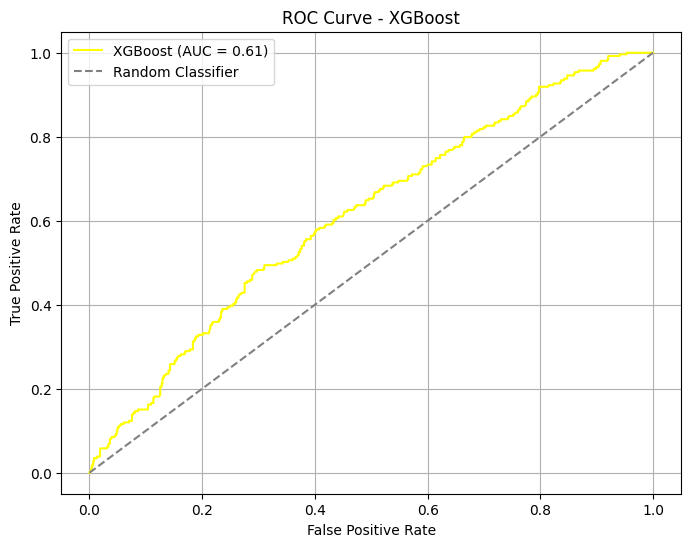

In [57]:
# Predict probabilities for the positive class using the XGBoost model
y_probs_xgb = xgb_best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for the XGBoost model
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)

# Calculate the AUC (Area Under the Curve) for the XGBoost model
auc_xgb = roc_auc_score(y_test, y_probs_xgb)

# Plot the ROC curve for the XGBoost model
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', color='yellow')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

**Model Selection and Evaluation**


Logistic Regression Evaluation:
Logistic Regression Performance:
Accuracy: 0.7410
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
AUC-ROC: 0.6035


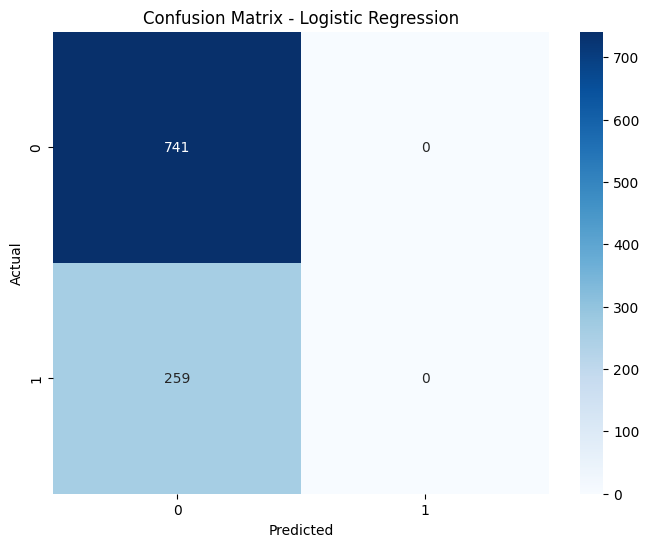


Decision Tree Evaluation:
Decision Tree Performance:
Accuracy: 0.7410
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
AUC-ROC: 0.6071


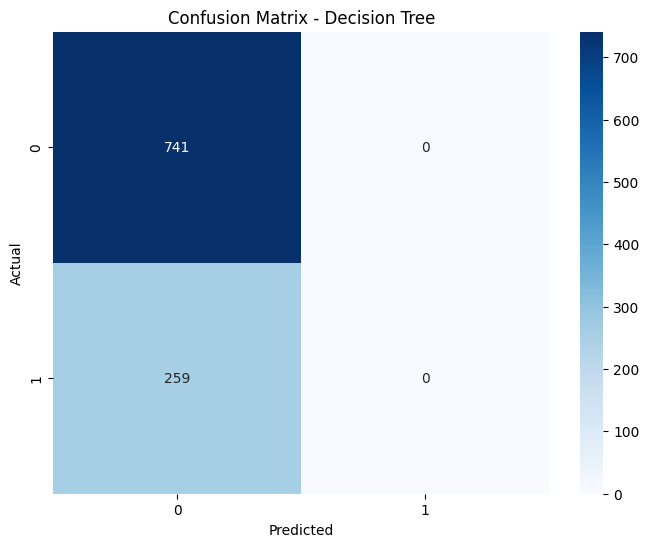


RandomForest Evaluation:
RandomForest Performance:
Accuracy: 0.7370
Precision: 0.3750
Recall: 0.0232
F1-score: 0.0436
AUC-ROC: 0.6041


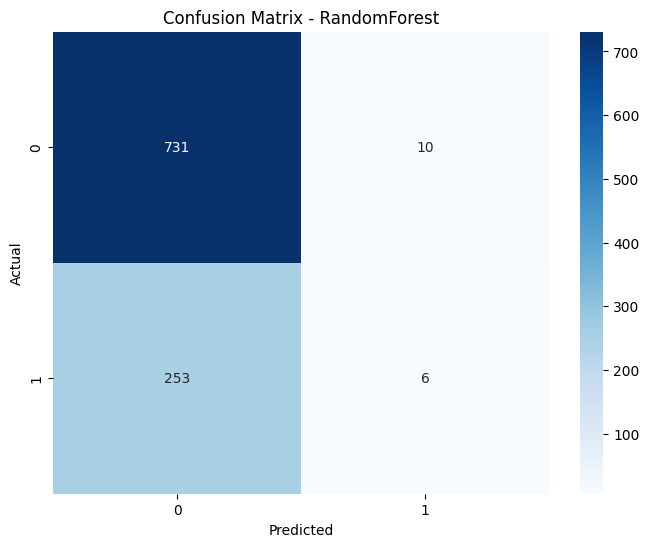


XGBoost Evaluation:
XGBoost Performance:
Accuracy: 0.7420
Precision: 0.5455
Recall: 0.0232
F1-score: 0.0444
AUC-ROC: 0.6134


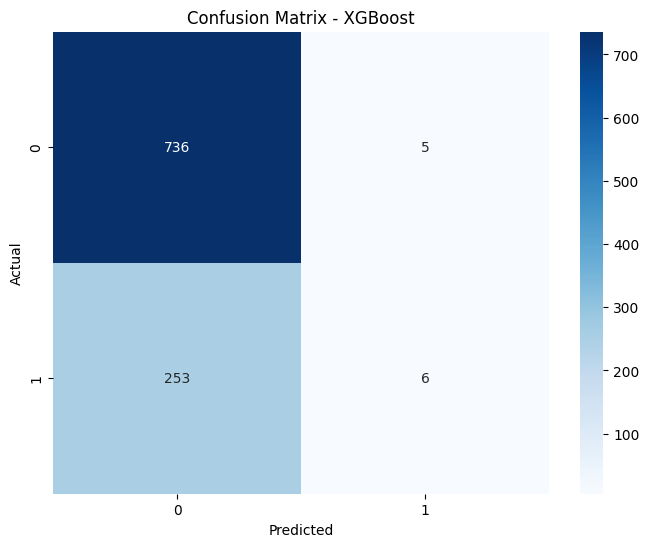


Best Model: Logistic Regression


In [58]:
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)

    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("\nLogistic Regression Evaluation:")
evaluate_model(lr_best_model, X_test, y_test, "Logistic Regression")

print("\nDecision Tree Evaluation:")
evaluate_model(dt_best_model, X_test, y_test, "Decision Tree")

print("\nRandomForest Evaluation:")
evaluate_model(rf_best_model, X_test, y_test, "RandomForest")

print("\nXGBoost Evaluation:")
evaluate_model(xgb_best_model, X_test, y_test, "XGBoost")

# # Select the best model (you can change this based on your preferred metric)
best_model = max([(lr_best_model, lr_random_search.best_score_, "Logistic Regression"),
                  (dt_best_model, dt_random_search.best_score_, "Decision Tree"),
                  (xgb_best_model, xgb_random_search.best_score_, "XGBoost")], key=lambda x: x[1])[0]

best_model_name = "XGBoost" if best_model == xgb_best_model else ("Logistic Regression" if best_model == lr_best_model else "Decision Tree")
print(f"\nBest Model: {best_model_name}")

In [70]:
import shap

# Feature Importance for Tree-Based Models (Decision Tree and XGBoost)
if best_model_name in ["Decision Tree", "XGBoost"]:
    feature_importance = best_model.named_steps['classifier'].feature_importances_
    feature_names = numeric_features + best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.show()

    # SHAP Values for Model Interpretability
    explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
    shap_values = explainer.shap_values(X_test_processed)

    top_feature = feature_importance_df['feature'].iloc[0]
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(top_feature, shap_values, X_test_processed, feature_names=feature_names)
    plt.title(f'SHAP Dependence Plot for {top_feature} - {best_model_name}')
    plt.show()

    print("SHAP Values Shape:", shap_values.shape)
    print("Feature Names:", feature_names)
else:
    print(f"{best_model_name} does not support feature importance or SHAP values.")


Logistic Regression does not support feature importance or SHAP values.



Logistic Regression Coefficients:
                           Feature  Coefficient
8      ContractType_Month-to-month     0.071102
1                   MonthlyCharges     0.051527
17            PaperlessBilling_Yes     0.048035
14     InternetService_Fiber optic     0.046930
4            AverageMonthlyCharges     0.045107
20  PaymentMethod_Electronic check     0.039759
11                  TechSupport_No     0.034534
7                      Gender_Male     0.020942
0                              Age     0.017539
21      PaymentMethod_Mailed check    -0.006701
5            CustomerLifetimeValue    -0.014242
19       PaymentMethod_Credit card    -0.014553
10           ContractType_Two year    -0.018059
15              InternetService_No    -0.018292
18     PaymentMethod_Bank transfer    -0.018505
6                    Gender_Female    -0.020942
13             InternetService_DSL    -0.028637
2                     TotalCharges    -0.028950
12                 TechSupport_Yes    -0.034534
16   

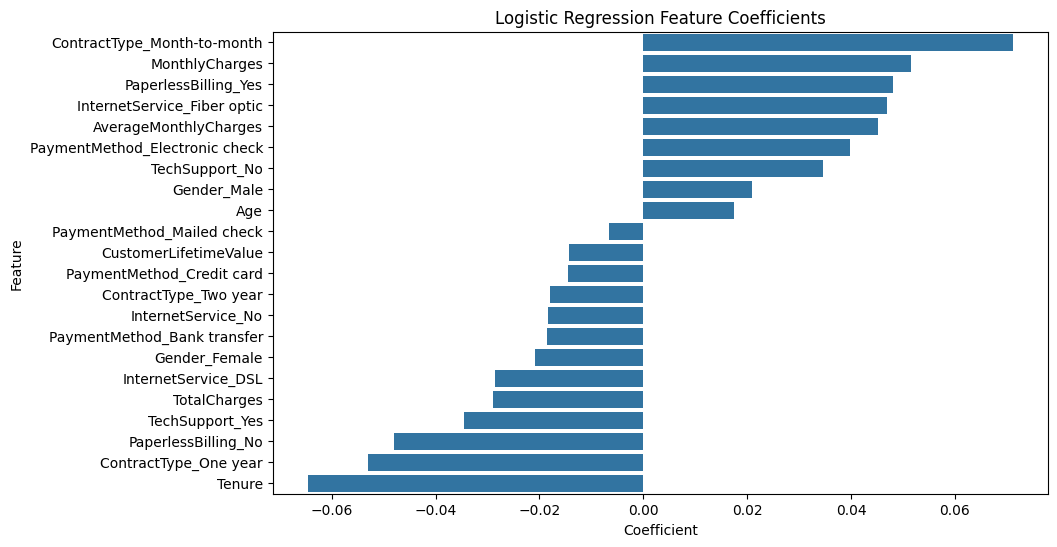

In [69]:
# Interpreting Coefficients of Logistic Regression
coefficients = lr_best_model.named_steps['classifier'].coef_[0]
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression Coefficients:")
print(coef_df)

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Logistic Regression Feature Coefficients')
plt.show()
import shap
explainer = shap.LinearExplainer(lr_best_model.named_steps['classifier'], X_train_processed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_processed)


Conclusion:
We've successfully built a customer churn prediction model for a telecom company using synthetic data.
The model can help identify customers at high risk of churning, allowing the company to take proactive measures.
The steps outlined above ensure that the entire process from data generation to model interpretability is reproducible and transparent. This approach helps in understanding the model's behavior and ensures that the results can be replicated by others.